In [19]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TSMixerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank
)
import json
import shap
from numpy.lib.stride_tricks import sliding_window_view
from darts.explainability.explainability_result import ComponentBasedExplainabilityResult

In [20]:
result_path = 'results/TSMixer/'

In [21]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [22]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
        "future":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [23]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_forecasts = None
# Define model parameters

# Set up time series cross-validation with 5 folds, respecting temporal order of data
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTraining the model...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Fit the scaler only on training data to avoid data leakage
    scaler = scaler.fit(train_fold)
    # Transform all time series
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TSMixerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=61,
        output_chunk_length=1,
        hidden_size=128,
        ff_size=153,
        n_epochs=30,
        batch_size=22,
        norm_type="TimeBatchNorm2d",
        normalize_before=False,
        num_blocks=3,
        activation="GELU",
        dropout=0.15000000000000002,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True, # Importante para que cada iteração treine do zero com este model_name
        optimizer_kwargs={"lr": 0.0004332871234178122, "weight_decay": 1e-5},
    )
    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11}
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    # Generate historical forecasts to evaluate model performance on past data
    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    )


    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Training the model...
Train set: 1389 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | HuberLoss        | 0      | train
1 | train_criterion       | HuberLoss        | 0      | train
2 | val_criterion         | HuberLoss        | 0      | train
3 | train_metrics         | MetricCollection | 0      | train
4 | val_metrics           | MetricCollection | 0      | train
5 | fc_hist               | Linear           | 62     | train
6 | feature_mixing_hist   | _FeatureMixing   | 27.9 K | train
7 | feature_mixing_future | _FeatureMixing   | 22.8 K | train
8 | conditional_mixer     | ModuleList       | 170 K  | train
9 | fc_out                | Linear           | 1.0 K  | train
-------------------------------------------------------------------
222 K     Trainable par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 7.118


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.306 >= min_delta = 0.001. New best score: 6.812


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.070 >= min_delta = 0.001. New best score: 6.743


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 6.701


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 6.701. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | HuberLoss        | 0      | train
1 | trai

O R2 desse fold foi -7.455990958894226

Fold 2

Training the model...
Train set: 2773 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.009. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | criterion             | HuberLoss        | 0      | train
1 | trai

O R2 desse fold foi 0.8747070635121639

Fold 3

Training the model...
Train set: 4157 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Ty

O R2 desse fold foi -inf

Fold 4

Training the model...
Train set: 5541 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.018


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.011


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type             | Params | Mode 
--------------------------------

O R2 desse fold foi -inf

Fold 5

Training the model...
Train set: 6925 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.027


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.019


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.012. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


O R2 desse fold foi -2.19726963704234
O melhor fold foi 2


In [24]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TSMixerModel(output_chunk_shift=0, hidden_size=128, ff_size=153, num_blocks=3, activation=GELU, dropout=0.15000000000000002, norm_type=TimeBatchNorm2d, normalize_before=False, use_static_covariates=True, model_name=model_2, input_chunk_length=61, output_chunk_length=1, n_epochs=30, batch_size=22, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f0aec4e2ae0>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0004332871234178122, 'weight_decay': 1e-05})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE        RMSE         MAE        R2  \
Temperature                    3.451365    1.857785    1.376595  0.923567   
Precipitation_accumulated    140.504698   11.853468    6.714515  0.996618   
Humidity                      14.709487    3.835295    2.765893  0.922466   
Wind_Speed_kmh                 0.051005    0.225843    0.154860  0.831638   
Soil_Moisture              65274.155893  255.488074  182.378955  0.950294   
Soil_Temperature               6.127990    2.475478    1.603532  0.867077   
Wind_Dir_Sin                   0.066532    0.257938    0.162032  0.805687   
Wind_Dir_Cos                   0.117240    0.342404    0.212896  0.815157   

                               SMAPE  
Temperature                 9.403405  
Precipitation_accumulated  14.437584  
Humidity                    3.622252  
Wind_Speed_kmh             86.709484  
Soil_Moisture               2.586598

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_1.png


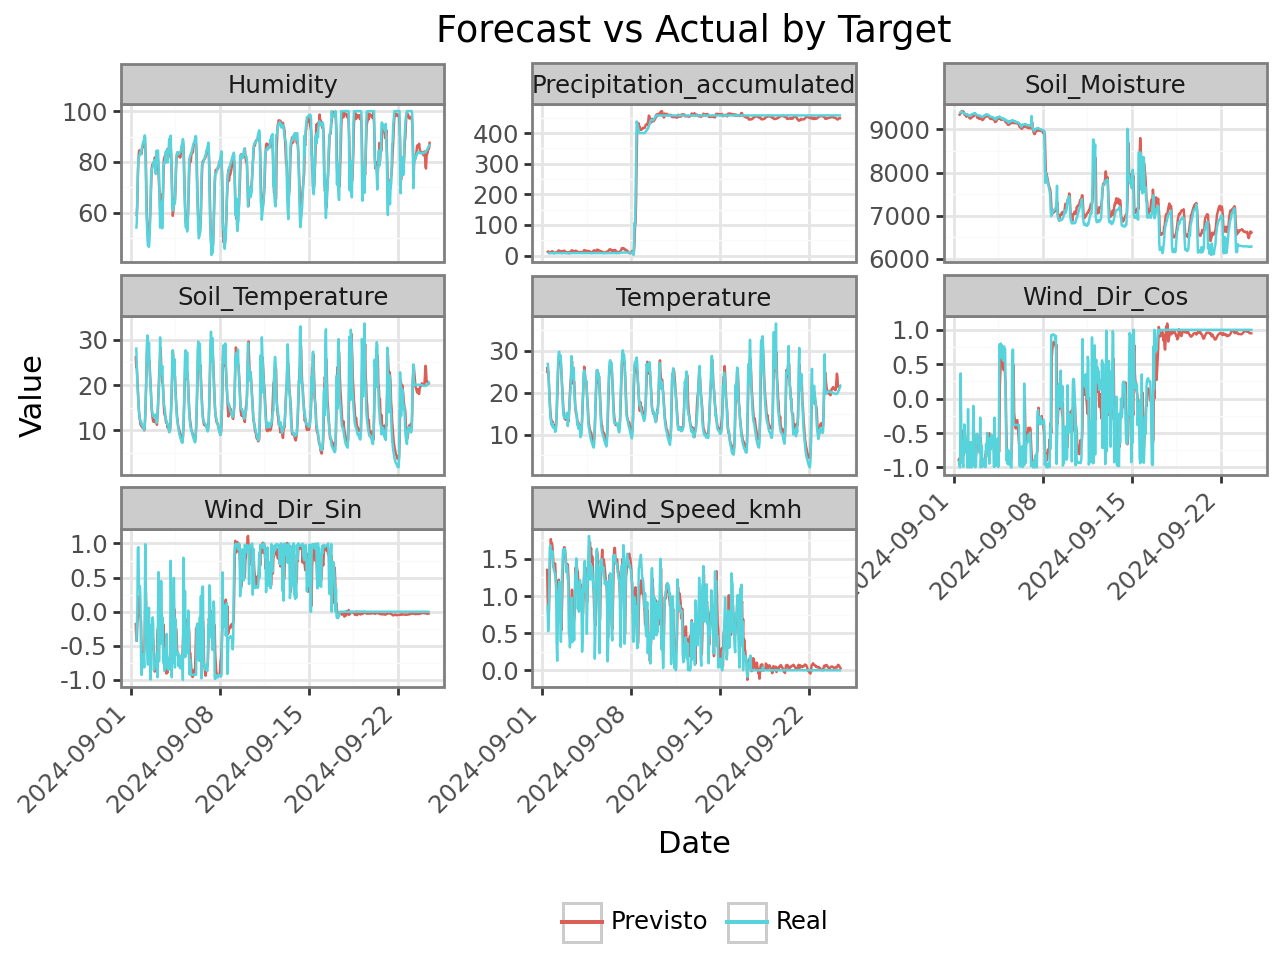

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    12.032488    3.468788    2.777220  0.732555   
Precipitation_accumulated    1324.696193   36.396376   15.618012  0.967790   
Humidity                       51.558270    7.180409    5.767240  0.726039   
Wind_Speed_kmh                  0.114168    0.337888    0.258254  0.624739   
Soil_Moisture              216578.248486  465.379682  382.355297  0.833298   
Soil_Temperature               12.883882    3.589412    2.750611  0.719569   
Wind_Dir_Sin                    0.083593    0.289124    0.207321  0.756231   
Wind_Dir_Cos                    0.185655    0.430877    0.301339  0.706510   

                                SMAPE  
Temperature                 18.724105  
Precipitation_accumulated   27.870400  
Humidity                     7.364913  
Wind_Speed_kmh              97.015850  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_6.png


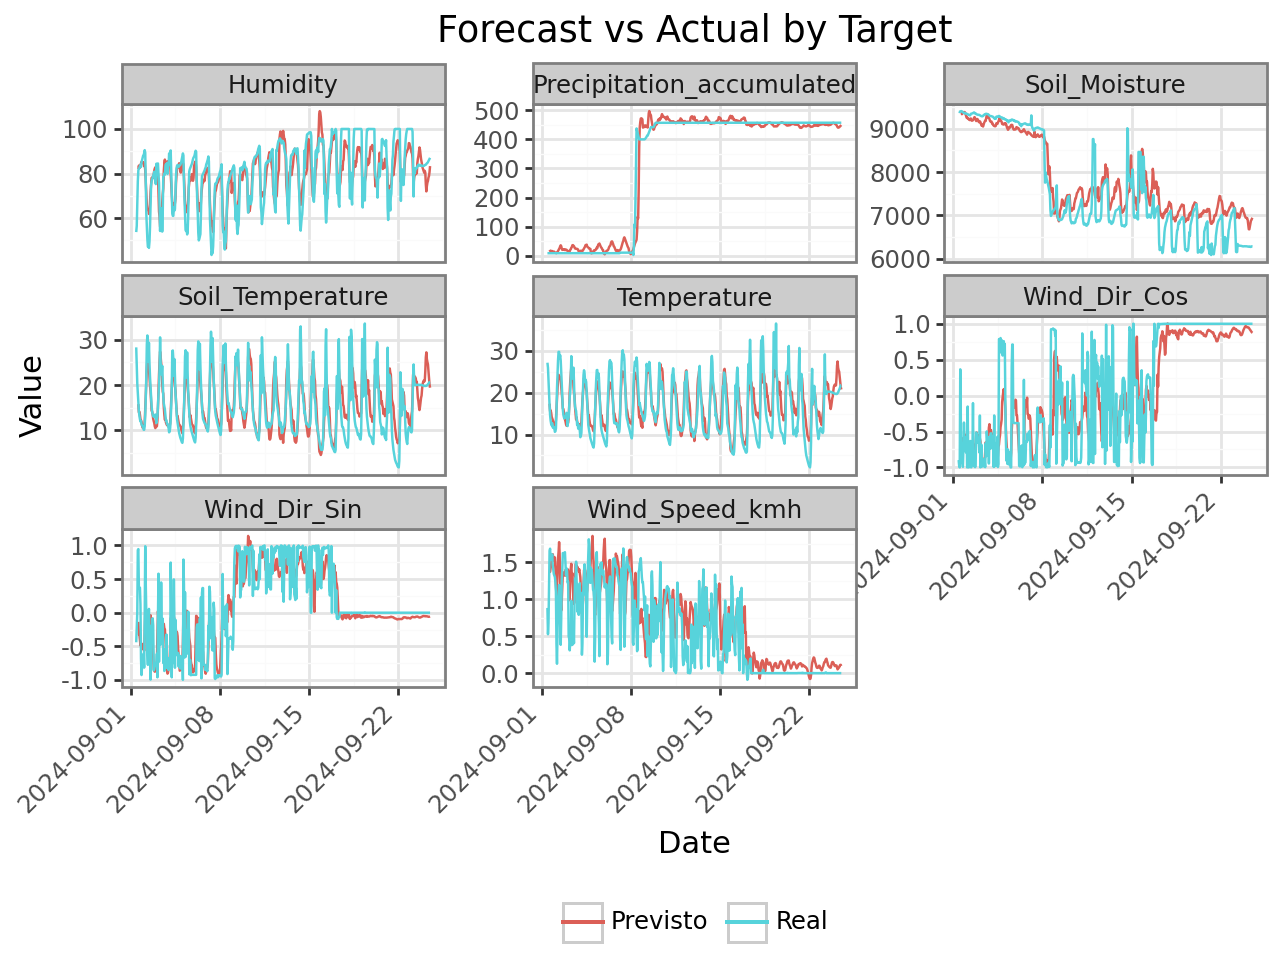

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    16.391012    4.048582    3.060762  0.638852   
Precipitation_accumulated    2774.135877   52.670066   22.628379  0.931464   
Humidity                       70.175829    8.377101    6.581170  0.631121   
Wind_Speed_kmh                  0.118225    0.343839    0.265103  0.600222   
Soil_Moisture              293783.119456  542.017638  454.701193  0.769952   
Soil_Temperature               16.787234    4.097223    3.092576  0.638029   
Wind_Dir_Sin                    0.083779    0.289445    0.210056  0.756393   
Wind_Dir_Cos                    0.199060    0.446161    0.318005  0.683869   

                                SMAPE  
Temperature                 20.776915  
Precipitation_accumulated   34.494834  
Humidity                     8.248113  
Wind_Speed_kmh              96.852050  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_12.png


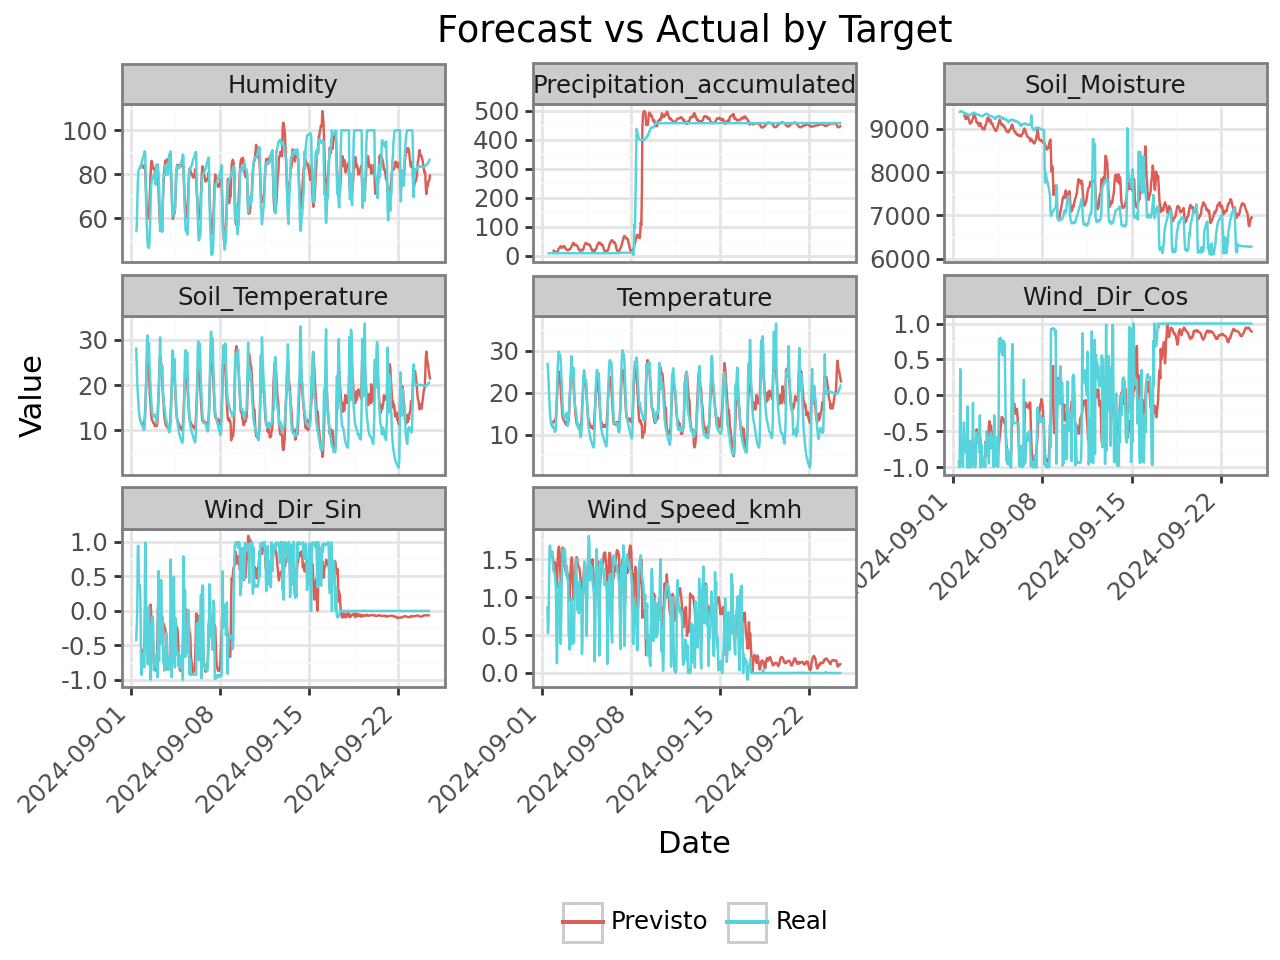

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    14.597273    3.820638    2.896189  0.677940   
Precipitation_accumulated    5199.731519   72.109164   33.374581  0.866871   
Humidity                       72.741163    8.528843    6.697520  0.617328   
Wind_Speed_kmh                  0.124544    0.352908    0.275503  0.575624   
Soil_Moisture              379385.174800  615.942509  530.535881  0.692337   
Soil_Temperature               16.397749    4.049413    3.102761  0.645331   
Wind_Dir_Sin                    0.085521    0.292439    0.216481  0.748595   
Wind_Dir_Cos                    0.217845    0.466739    0.341594  0.652173   

                                SMAPE  
Temperature                 20.139612  
Precipitation_accumulated   42.771398  
Humidity                     8.416641  
Wind_Speed_kmh              98.572866  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_24.png


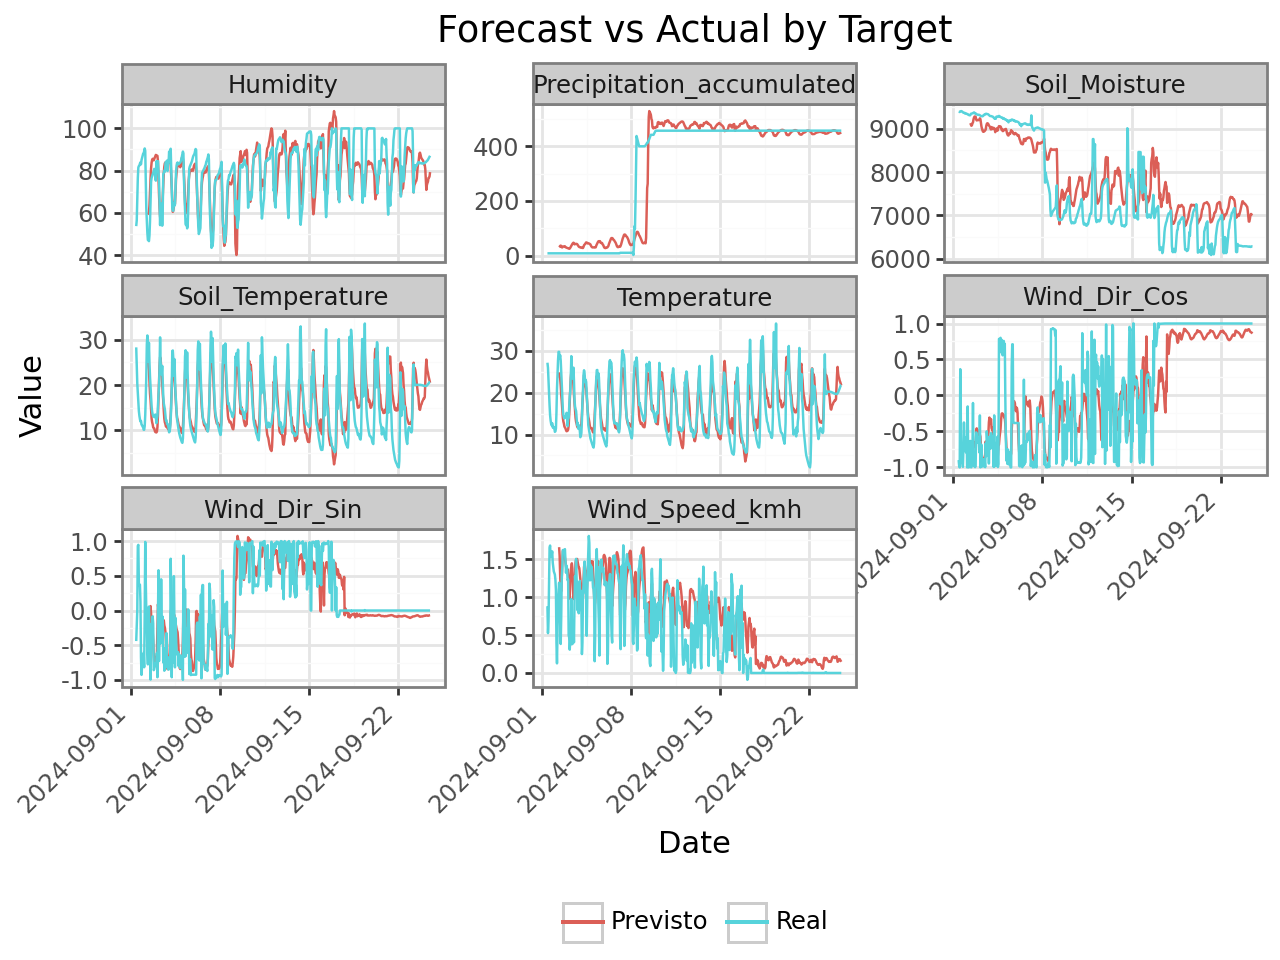

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    23.066834    4.802794    3.662493  0.492177   
Precipitation_accumulated    8024.011837   89.576849   46.666951  0.775072   
Humidity                      115.770557   10.759673    8.504312  0.376088   
Wind_Speed_kmh                  0.159196    0.398994    0.316828  0.438146   
Soil_Moisture              496697.211630  704.767488  614.639855  0.560408   
Soil_Temperature               26.195482    5.118152    3.912503  0.435066   
Wind_Dir_Sin                    0.144226    0.379770    0.274308  0.566886   
Wind_Dir_Cos                    0.261508    0.511379    0.382025  0.573331   

                                SMAPE  
Temperature                 25.700681  
Precipitation_accumulated   43.776607  
Humidity                    10.648282  
Wind_Speed_kmh             103.605856  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_48.png


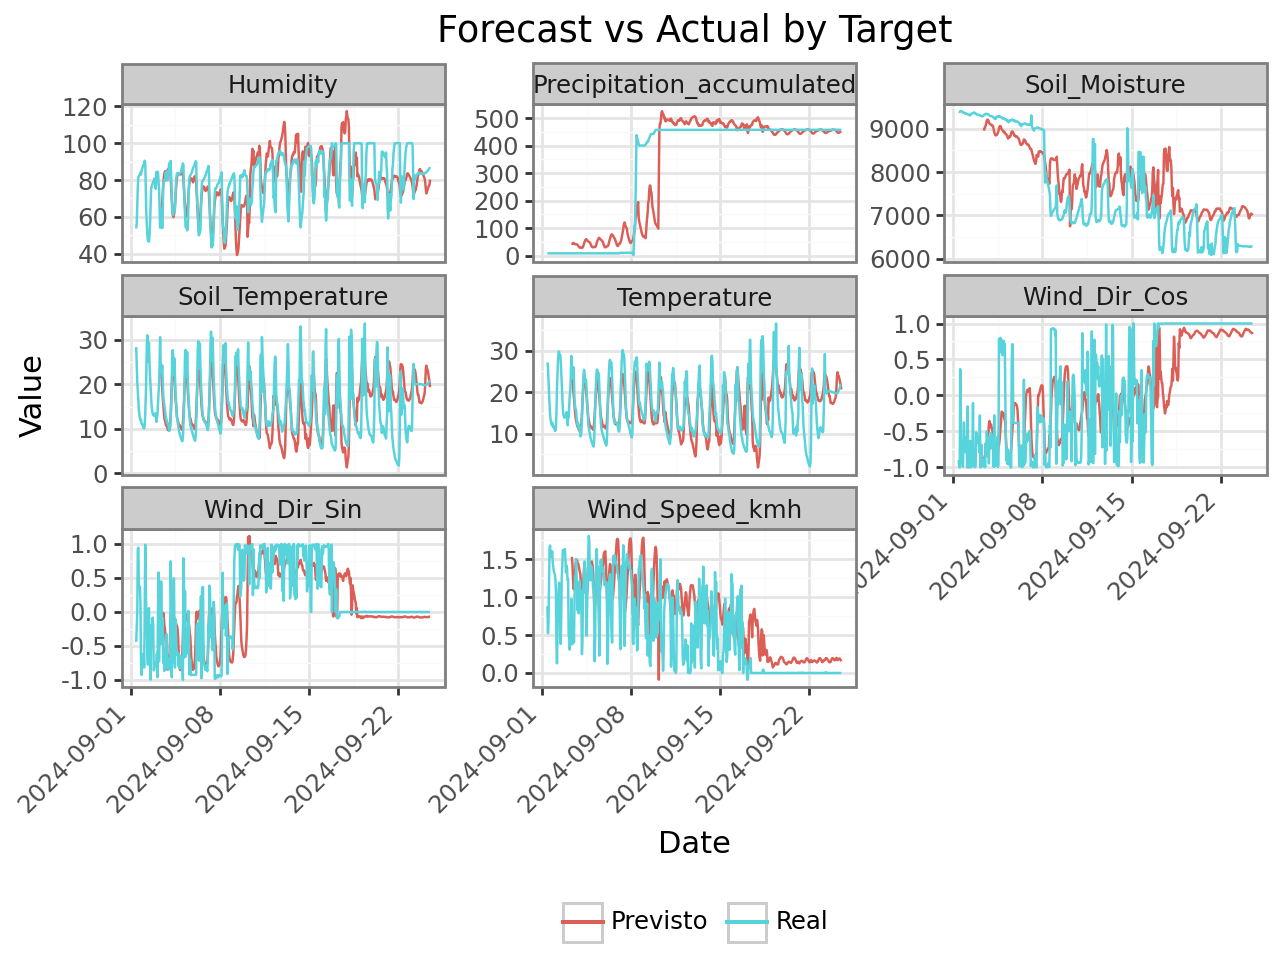

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                     MSE        RMSE         MAE        R2  \
Temperature                    29.169500    5.400880    4.266629  0.367321   
Precipitation_accumulated    3745.873844   61.203544   36.493390  0.880750   
Humidity                      192.924863   13.889739   11.544148 -0.027567   
Wind_Speed_kmh                  0.158592    0.398236    0.313373  0.441693   
Soil_Moisture              582714.366855  763.357300  642.876541  0.420496   
Soil_Temperature               33.521967    5.789816    4.582360  0.285913   
Wind_Dir_Sin                    0.112817    0.335882    0.251073  0.645615   
Wind_Dir_Cos                    0.278496    0.527728    0.407170  0.535282   

                                SMAPE  
Temperature                 30.933183  
Precipitation_accumulated   34.733427  
Humidity                    14.426291  
Wind_Speed_kmh             107.374295  
Soil_Moisture         

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_72.png


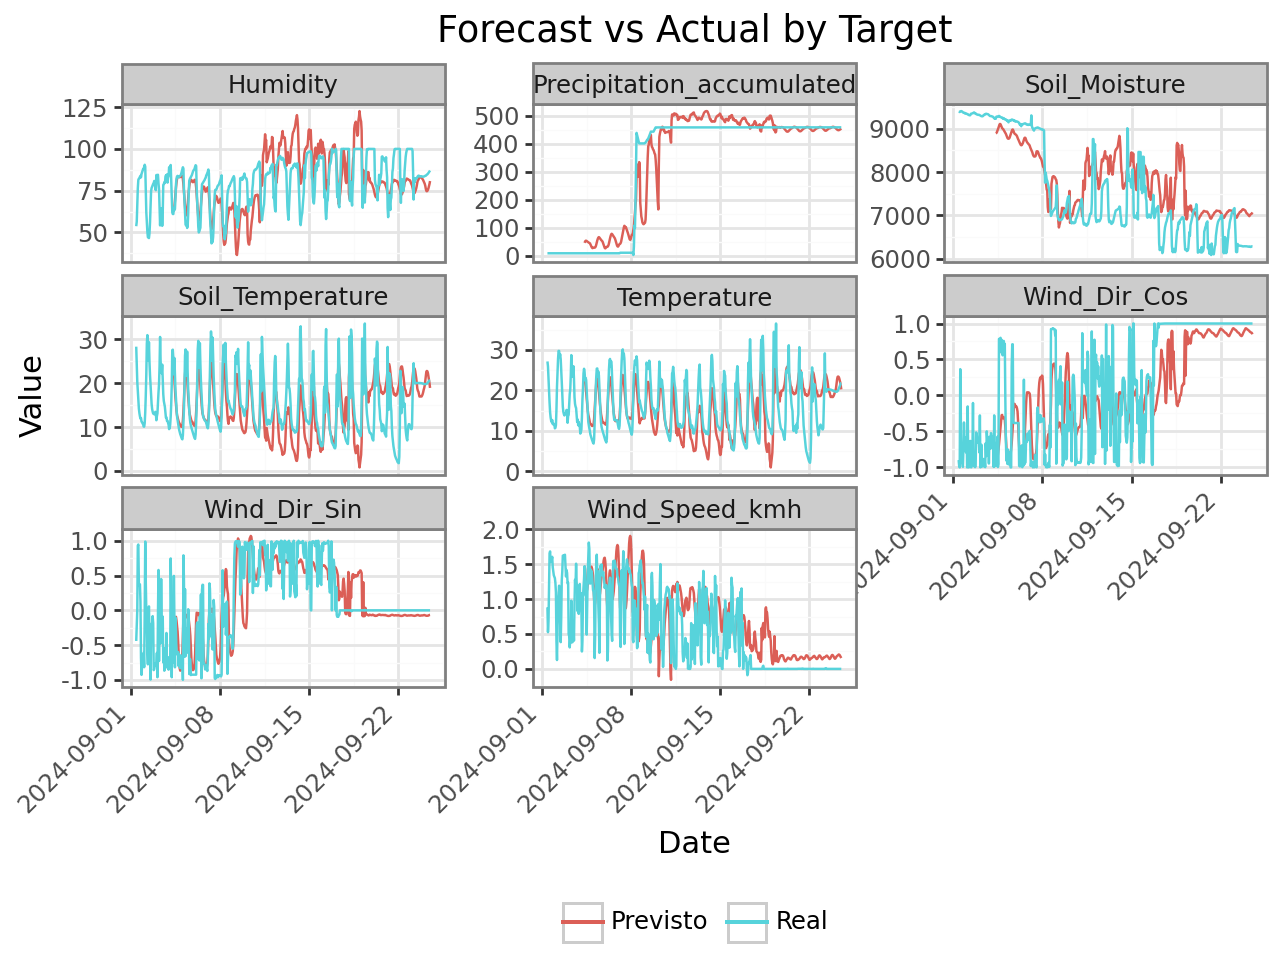

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE         RMSE          MAE         R2  \
Temperature                5.203893e+01     7.213802     5.781736  -0.145351   
Precipitation_accumulated  6.598732e+03    81.232577    44.023306 -16.929391   
Humidity                   4.030450e+02    20.075979    17.114779  -1.441701   
Wind_Speed_kmh             4.442915e-01     0.666552     0.517072  -1.357283   
Soil_Moisture              1.872106e+06  1368.249333  1167.773239  -5.062560   
Soil_Temperature           5.678885e+01     7.535838     6.043559  -0.241677   
Wind_Dir_Sin               1.160563e-01     0.340670     0.280138   0.415638   
Wind_Dir_Cos               3.992914e-01     0.631895     0.507675   0.238627   

                                SMAPE  
Temperature                 48.196483  
Precipitation_accumulated   12.625785  
Humidity                    19.083253  
Wind_Speed_kmh             133.478264  
Soil

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//previsao_vs_real_168.png


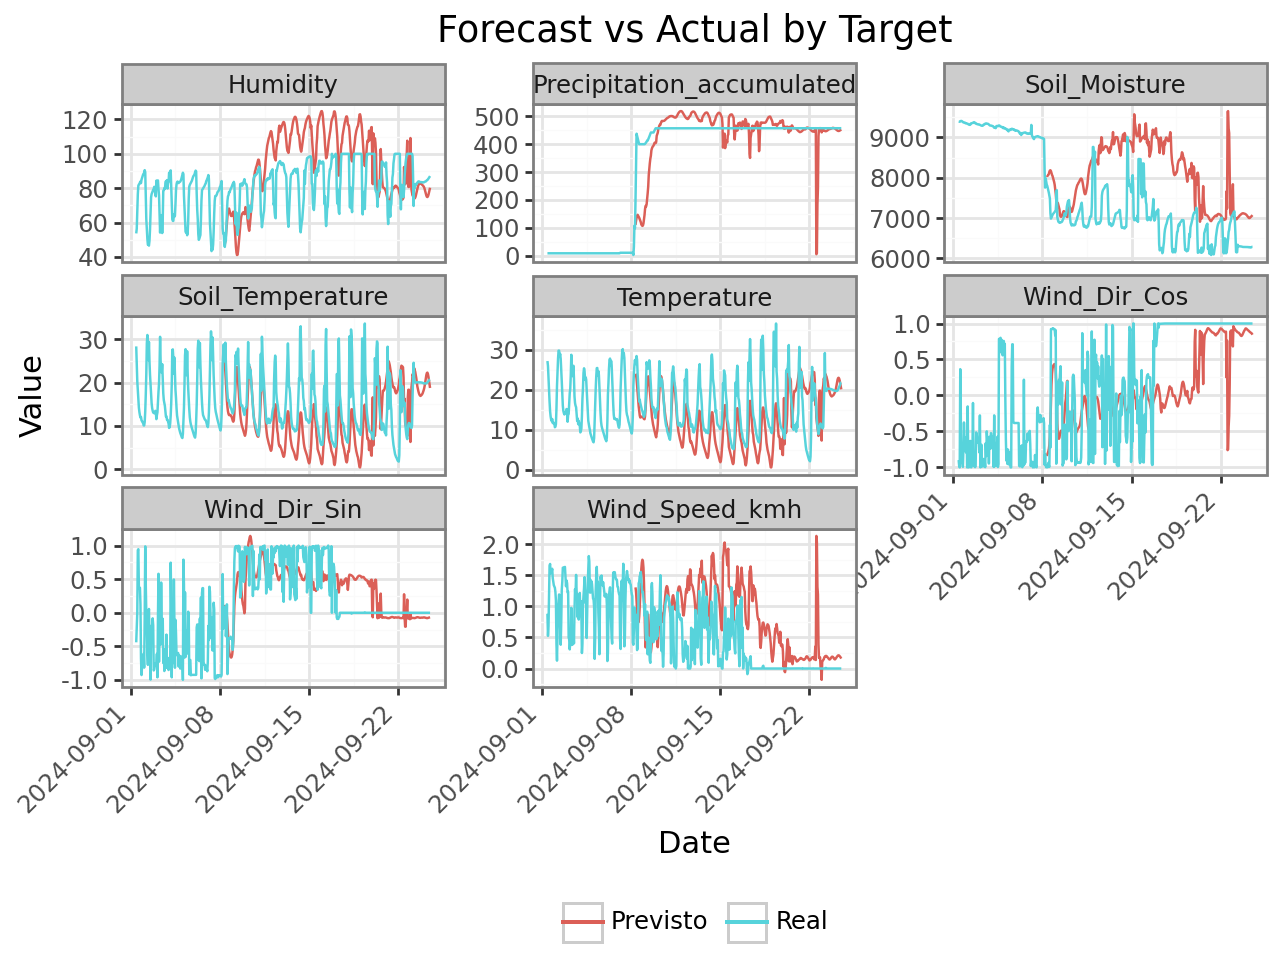

In [25]:
for forecast_horizon in [1,6,12,24,48,72,168]:
    forecasts = model.historical_forecasts(
        best_train_scaled,
        start=0.8,
        forecast_horizon=forecast_horizon,
        stride=1,
        retrain=False,
        last_points_only=True,
        predict_kwargs={"dataloader_kwargs":{"num_workers": 11}}
    )

    forecasts_t = best_scaler.inverse_transform(forecasts)
    s = best_scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Starting time series verification for consistency...")
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], forecasts_t[target]),
            'RMSE': rmse(s[target], forecasts_t[target]),
            'MAE': mae(s[target], forecasts_t[target]),
            'R2': r2_score(s[target], forecasts_t[target]),
            'SMAPE': smape(s[target], forecasts_t[target]),
        }
    metrics_df = pd.DataFrame(metrics).T
    print("\nPerformance metrics:")
    print(metrics_df)

    s_df = s.to_dataframe()
    s_df = s_df.reset_index()
    forecasts_t_df = forecasts_t.to_dataframe()
    forecasts_t_df = forecasts_t_df.reset_index()
    forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
    print(forecasts_t_df.columns)

    plot_columns = ['Timestamp'] + target_columns
    s_melted = s_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    s_melted['type'] = 'Real'

    forecasts_t_melted = forecasts_t_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    forecasts_t_melted['type'] = 'Previsto'

    # Concatena os DataFrames 'Real' e 'Previsto'
    df_combined = pd.concat([s_melted, forecasts_t_melted])

    # Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
    df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

    plot = (
            ggplot(df_combined, aes(x='Date', y='value', color='type'))
            + geom_line()
            + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
            + labs(
        title='Forecast vs Actual by Target',
        x='Date',
        y='Value',
        color='Data Type' # Legend for color
    )
            + theme_bw()
            + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
        legend_position='bottom', # Places legend at the bottom
        legend_title=element_blank(), # Removes legend title
    )
    )

    plot.save(f'{result_path}/previsao_vs_real_{forecast_horizon}.png', width=12, height=10, dpi=300)
    plot.show()

    with open(f'{result_path}/metrics_{forecast_horizon}.json', 'w') as f:
        json.dump(metrics_df.to_dict(), f, indent=4)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

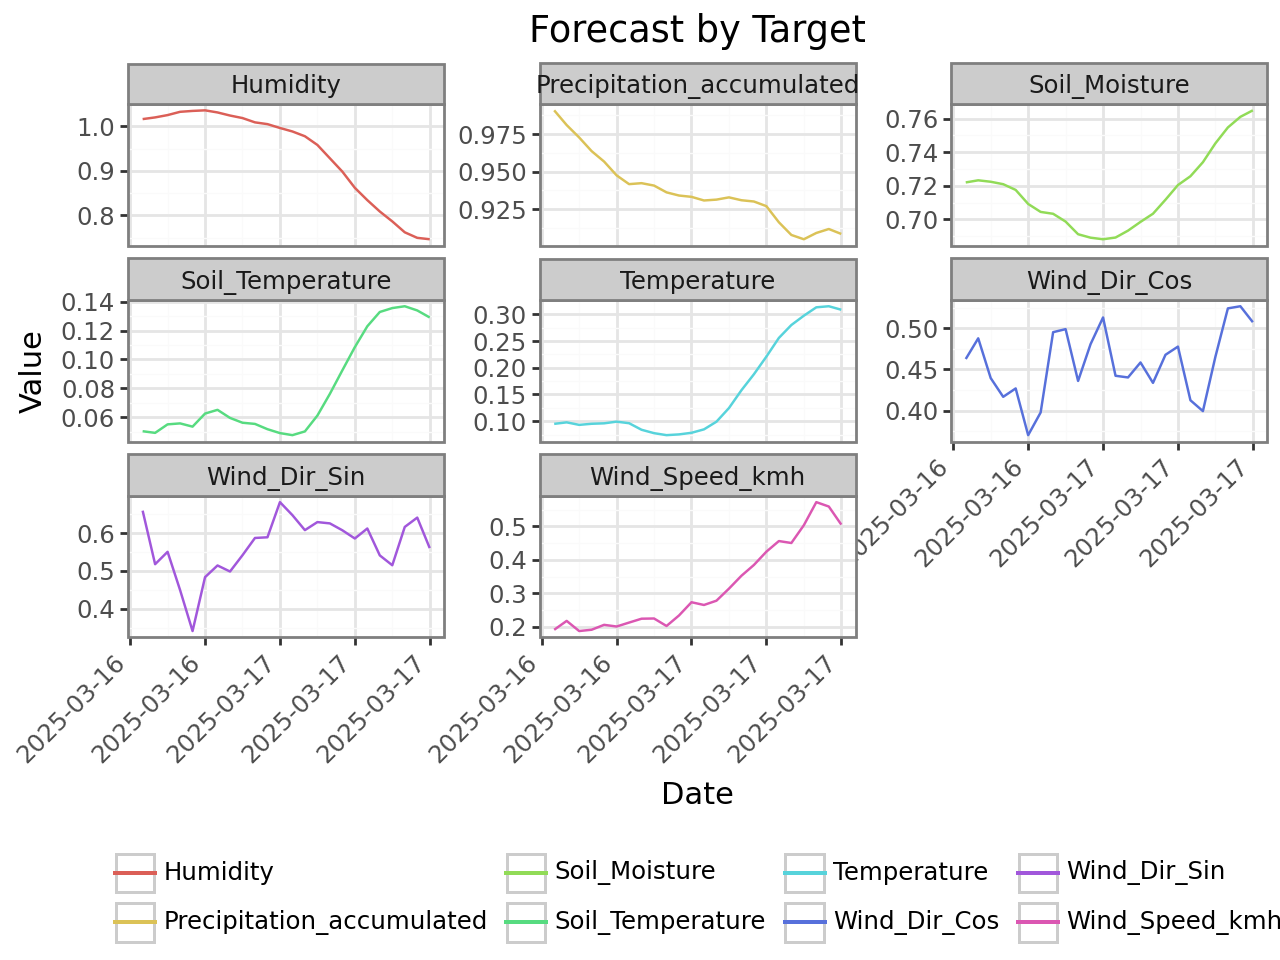

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TSMixer//pred_future_24.png


In [26]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
        ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
        + labs(
    title='Forecast by Target',
    x='Date',
    y='Value',
    color='Data Type' # Legend for color
)
        + theme_bw()
        + theme(
    axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
    legend_position='bottom', # Places legend at the bottom
    legend_title=element_blank(), # Removes legend title

)
)
plot.show()
plot.save(f'{result_path}/pred_future_24.png', width=12, height=10, dpi=300)
